In [3]:
import sys
try:
    import pandas as pd
except ImportError as e:
    print("pandas is required for this example. Please install with conda or pip  and then try again.")
    sys.exit()

import numpy as np
import sklearn
from sklearn import ensemble
import kmapper as km
from kmapper.plotlyviz import * 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [4]:
import plotly.graph_objs as go
from ipywidgets import (HBox, VBox)

In [12]:
#Data - the Wisconsin Breast Cancer Dataset
#https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

df = pd.read_csv('data.csv')
feature_names = [c for c in df.columns if c not in ["id", "diagnosis"]]
df["diagnosis"] = df["diagnosis"].apply(lambda x: 1 if x == "M" else 0)
X = np.array(df[feature_names].fillna(0))
y = np.array(df["diagnosis"])

# Create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# Create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=0)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine lenses pairwise to get a 2-D lens i.e. [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]
# Define the simplicial complex
scomplex = mapper.map(lens,
                      X,
                      cover=km.Cover(n_cubes=15,
                                     perc_overlap=0.7),
                      clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                       random_state=3471))


In [13]:
pl_brewer = [[0.0, '#006837'],
             [0.1, '#1a9850'],
             [0.2, '#66bd63'],
             [0.3, '#a6d96a'],
             [0.4, '#d9ef8b'],
             [0.5, '#ffffbf'],
             [0.6, '#fee08b'],
             [0.7, '#fdae61'],
             [0.8, '#f46d43'],
             [0.9, '#d73027'],
             [1.0, '#a50026']]

In [14]:
color_values = lens [:,0] - lens[:,0].min()
my_colorscale = pl_brewer
kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex,
                                                                 color_values,
                                                                 color_function_name='Distance to x-min',
                                                                 colorscale=my_colorscale)

# assign to node['custom_tooltips']  the node label (0 for benign, 1 for malignant)
for node in kmgraph['nodes']:
    node['custom_tooltips'] = y[scomplex['nodes'][node['name']]]

In [15]:
bgcolor = 'rgba(10,10,10, 0.9)'
y_gridcolor = 'rgb(150,150,150)'# on a black background the gridlines are set on  grey

In [16]:
plotly_graph_data = plotly_graph(kmgraph, graph_layout='fr', colorscale=my_colorscale,
                                 factor_size=2.5, edge_linewidth=0.5)
layout = plot_layout(title='Topological network representing the<br>  breast cancer  dataset',
                     width=620, height=570,
                     annotation_text=get_kmgraph_meta(mapper_summary),
                     bgcolor=bgcolor)

fw_graph = go.FigureWidget(data=plotly_graph_data, layout=layout)
fw_hist = node_hist_fig(colorf_distribution, bgcolor=bgcolor,
                        y_gridcolor=y_gridcolor)
fw_summary = summary_fig(mapper_summary, height=300)
dashboard = hovering_widgets(kmgraph,
                             fw_graph,
                             ctooltips=True, # ctooltips = True, because we assigned a label to each
                                             #cluster member
                             bgcolor=bgcolor,
                             y_gridcolor=y_gridcolor,
                             member_textbox_width=600)

#Update the fw_graph colorbar, setting its title:

fw_graph.data[1].marker.colorbar.title = 'dist to<br>x-min'

In [17]:
VBox([fw_graph, HBox([fw_summary, fw_hist])])

    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

In [19]:
dashboard

    'data': [{'hoverinfo': 'none',
              'line': {'color'…

In [20]:
breastc_dict = {0: 'benign', 1: 'malignant'}
tooltips = list(fw_graph.data[1].text) # we perform this conversion because fw.data[1].text is a tuple and we want to update
                                     # the tooltips

new_color = []
for j, node in enumerate(kmgraph['nodes']):
    member_label_ids = y[scomplex['nodes'][node['name']]]
    member_labels = [breastc_dict[id] for id in member_label_ids]
    label_type, label_counts = np.unique(member_labels, return_counts=True)

    n_members = label_counts.sum()
    if label_type.shape[0] == 1:
        if label_type[0] == 'benign':
            new_color.append(0)
        else:
            new_color.append(1)
    else:
        new_color.append(1.0*label_counts[1]/n_members)#multiply by 1 for python 2.7.+

    for m in range(len(label_counts)):
        tooltips[j] += '<br>' + str(label_type[m]) + ': ' + str(label_counts[m]) # append  how many benign/malign
                                                                                 # members exist in each node

fwn_graph = go.FigureWidget(fw_graph) # copy the initial FigureWidget

with fwn_graph.batch_update(): # make updates for the new figure
    fwn_graph.data[1].text = tooltips # add the new tooltips
    fwn_graph.data[1].marker.colorbar.x = -0.14 # place toolbar at the figure left side
    fwn_graph.layout.width = 550 # change the figure size in order to plot two "parallel" copies
    fwn_graph.layout.height = 550
    fwn_graph.layout.margin.r = 45 # decrease the right margin from 60px (default val) to 45 pixels

fw1 = go.FigureWidget(fwn_graph) # define a new figure from  the fwn_graph that will be colored by the new color function
with fw1.batch_update():
    fw1.data[1].marker.color = new_color # update node colors
    fw1.data[0].line.color = 'rgb(125,125,125)' # update the graph edge color
    fw1.layout.plot_bgcolor = 'rgb(240,240,240)'
    fw1.layout.annotations = None # remove the mapper_summary from the second plot
    fw1.data[1].marker.showscale = False # remove the colorbar
    fw1.layout.title = "Nodes are colored according to the proportion<br> of malignant members"

In [21]:
HBox([fwn_graph, fw1])

    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

In [22]:
# Create a 1-D lens with the First Principal Component from PCA
lens3 = mapper.fit_transform(X, projection=PCA(n_components=1))

# Combine lenses pairwise to get a 2-D lens i.e. [Isolation Forest, First Principal Component from PCA]
isoForest_pca = np.c_[lens1, lens3]


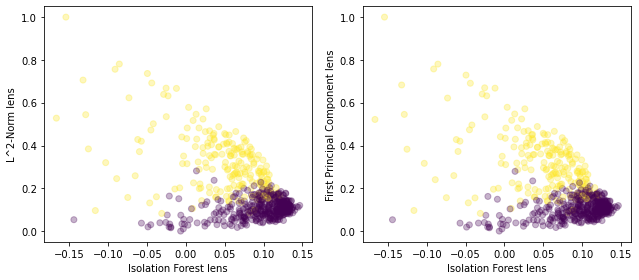

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(9,4))

axs[0].scatter(lens1,lens2,c=y.reshape(-1,1),alpha=0.3)
axs[0].set_xlabel('Isolation Forest lens')
axs[0].set_ylabel('L^2-Norm lens')

axs[1].scatter(lens1,lens3,c=y.reshape(-1,1),alpha=0.3)
axs[1].set_xlabel('Isolation Forest lens')
axs[1].set_ylabel('First Principal Component lens')

plt.tight_layout()

plt.show()

In [24]:
# Define the simplicial complexes

# one lens
scomplex_isoForest = mapper.map(lens1,
                      X,
                      cover=km.Cover(n_cubes=15,
                                     perc_overlap=0.7),
                      clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                       random_state=3471))

# two lenses
scomplex_isoForest_pca = mapper.map(isoForest_pca,
                      X,
                      cover=km.Cover(n_cubes=15,
                                     perc_overlap=0.7),
                      clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                       random_state=3471))

In [25]:
# visualise scomplex_isoForest
color_values = lens1[:,0] - lens1[:,0].min()
my_colorscale = pl_brewer

kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex_isoForest,
                                                                 color_values,
                                                                 color_function_name='Distance to x-min',
                                                                 colorscale=my_colorscale)


# assign to node['custom_tooltips']  the node label (0 for benign, 1 for malignant)
for node in kmgraph['nodes']:
    node['custom_tooltips'] = y[scomplex['nodes'][node['name']]]

bgcolor = 'rgba(10,10,10, 0.9)'
y_gridcolor = 'rgb(150,150,150)'# on a black background the gridlines are set on  grey
plotly_graph_data = plotly_graph(kmgraph, graph_layout='fr', colorscale=my_colorscale,
                                 factor_size=2.5, edge_linewidth=0.5)
layout = plot_layout(title='Topological network representing the<br>  breast cancer  dataset',
                     width=620, height=570,
                     annotation_text=get_kmgraph_meta(mapper_summary),
                     bgcolor=bgcolor)

fw_graph = go.FigureWidget(data=plotly_graph_data, layout=layout)
fw_hist = node_hist_fig(colorf_distribution, bgcolor=bgcolor,
                        y_gridcolor=y_gridcolor)
fw_summary = summary_fig(mapper_summary, height=300)
dashboard = hovering_widgets(kmgraph,
                             fw_graph,
                             ctooltips=True, # ctooltips = True, because we assigned a label to each
                                             #cluster member
                             bgcolor=bgcolor,
                             y_gridcolor=y_gridcolor,
                             member_textbox_width=600)

#Update the fw_graph colorbar, setting its title:

fw_graph.data[1].marker.colorbar.title = 'dist to<br>x-min'


VBox([fw_graph, HBox([fw_summary, fw_hist])])

    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

In [26]:
# visualise scomplex_isoForest_pca
color_values = isoForest_pca[:,0] - isoForest_pca[:,0].min()
my_colorscale = pl_brewer

kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex_isoForest_pca,
                                                                 color_values,
                                                                 color_function_name='Distance to x-min',
                                                                 colorscale=my_colorscale)


# assign to node['custom_tooltips']  the node label (0 for benign, 1 for malignant)
for node in kmgraph['nodes']:
    node['custom_tooltips'] = y[scomplex['nodes'][node['name']]]

bgcolor = 'rgba(10,10,10, 0.9)'
y_gridcolor = 'rgb(150,150,150)'# on a black background the gridlines are set on  grey
plotly_graph_data = plotly_graph(kmgraph, graph_layout='fr', colorscale=my_colorscale,
                                 factor_size=2.5, edge_linewidth=0.5)
layout = plot_layout(title='Topological network representing the<br>  breast cancer  dataset',
                     width=620, height=570,
                     annotation_text=get_kmgraph_meta(mapper_summary),
                     bgcolor=bgcolor)

fw_graph = go.FigureWidget(data=plotly_graph_data, layout=layout)
fw_hist = node_hist_fig(colorf_distribution, bgcolor=bgcolor,
                        y_gridcolor=y_gridcolor)
fw_summary = summary_fig(mapper_summary, height=300)
dashboard = hovering_widgets(kmgraph,
                             fw_graph,
                             ctooltips=True, # ctooltips = True, because we assigned a label to each
                                             #cluster member
                             bgcolor=bgcolor,
                             y_gridcolor=y_gridcolor,
                             member_textbox_width=600)

#Update the fw_graph colorbar, setting its title:

fw_graph.data[1].marker.colorbar.title = 'dist to<br>x-min'


In [27]:
VBox([fw_graph, HBox([fw_summary, fw_hist])])

    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

In [28]:
# Create a 1-D lens with the values of the texture_mean feature of the dataset
lens4 = mapper.fit_transform(X, projection=[1])

# Combine lenses pairwise to get a 2-D lens i.e. [Isolation Forest, First Principal Component from PCA]
texture_l2norm = np.c_[lens4, lens2]


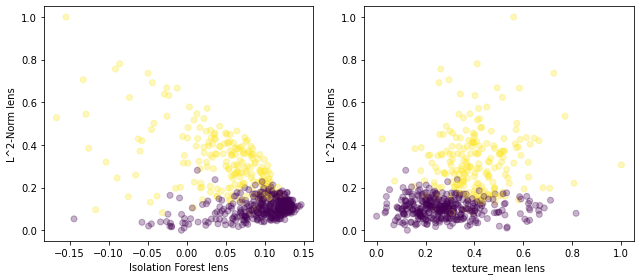

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(9,4))

axs[0].scatter(lens1,lens2,c=y.reshape(-1,1),alpha=0.3)
axs[0].set_xlabel('Isolation Forest lens')
axs[0].set_ylabel('L^2-Norm lens')

axs[1].scatter(lens4,lens2,c=y.reshape(-1,1),alpha=0.3)
axs[1].set_xlabel('texture_mean lens')
axs[1].set_ylabel('L^2-Norm lens')

plt.tight_layout()

plt.show()

In [30]:
# Define the simplicial complexes
# one lens
scomplex_texture = mapper.map(lens4,
                      X,
                      cover=km.Cover(n_cubes=15,
                                     perc_overlap=0.7),
                      clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                       random_state=3471))

# two lenses
scomplex_texture_l2norm = mapper.map(texture_l2norm,
                      X,
                      cover=km.Cover(n_cubes=15,
                                     perc_overlap=0.7),
                      clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                       random_state=3471))

In [31]:
# visualise scomplex_radius
color_values = lens4[:,0] - lens4[:,0].min()
my_colorscale = pl_brewer

kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex_texture,
                                                                 color_values,
                                                                 color_function_name='Distance to x-min',
                                                                 colorscale=my_colorscale)


# assign to node['custom_tooltips']  the node label (0 for benign, 1 for malignant)
for node in kmgraph['nodes']:
    node['custom_tooltips'] = y[scomplex['nodes'][node['name']]]

bgcolor = 'rgba(10,10,10, 0.9)'
y_gridcolor = 'rgb(150,150,150)'# on a black background the gridlines are set on  grey
plotly_graph_data = plotly_graph(kmgraph, graph_layout='fr', colorscale=my_colorscale,
                                 factor_size=2.5, edge_linewidth=0.5)
layout = plot_layout(title='Topological network representing the<br>  breast cancer  dataset',
                     width=620, height=570,
                     annotation_text=get_kmgraph_meta(mapper_summary),
                     bgcolor=bgcolor)

fw_graph = go.FigureWidget(data=plotly_graph_data, layout=layout)
fw_hist = node_hist_fig(colorf_distribution, bgcolor=bgcolor,
                        y_gridcolor=y_gridcolor)
fw_summary = summary_fig(mapper_summary, height=300)
dashboard = hovering_widgets(kmgraph,
                             fw_graph,
                             ctooltips=True, # ctooltips = True, because we assigned a label to each
                                             #cluster member
                             bgcolor=bgcolor,
                             y_gridcolor=y_gridcolor,
                             member_textbox_width=600)

#Update the fw_graph colorbar, setting its title:

fw_graph.data[1].marker.colorbar.title = 'dist to<br>x-min'


VBox([fw_graph, HBox([fw_summary, fw_hist])])

    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

In [32]:
# visualise scomplex_radius_l2norm
color_values = texture_l2norm[:,0] - texture_l2norm[:,0].min()
my_colorscale = pl_brewer

kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex_texture_l2norm,
                                                                 color_values,
                                                                 color_function_name='Distance to x-min',
                                                                 colorscale=my_colorscale)


# assign to node['custom_tooltips']  the node label (0 for benign, 1 for malignant)
for node in kmgraph['nodes']:
    node['custom_tooltips'] = y[scomplex['nodes'][node['name']]]

bgcolor = 'rgba(10,10,10, 0.9)'
y_gridcolor = 'rgb(150,150,150)'# on a black background the gridlines are set on  grey
plotly_graph_data = plotly_graph(kmgraph, graph_layout='fr', colorscale=my_colorscale,
                                 factor_size=2.5, edge_linewidth=0.5)
layout = plot_layout(title='Topological network representing the<br>  breast cancer  dataset',
                     width=620, height=570,
                     annotation_text=get_kmgraph_meta(mapper_summary),
                     bgcolor=bgcolor)

fw_graph = go.FigureWidget(data=plotly_graph_data, layout=layout)
fw_hist = node_hist_fig(colorf_distribution, bgcolor=bgcolor,
                        y_gridcolor=y_gridcolor)
fw_summary = summary_fig(mapper_summary, height=300)
dashboard = hovering_widgets(kmgraph,
                             fw_graph,
                             ctooltips=True, # ctooltips = True, because we assigned a label to each
                                             #cluster member
                             bgcolor=bgcolor,
                             y_gridcolor=y_gridcolor,
                             member_textbox_width=600)

#Update the fw_graph colorbar, setting its title:

fw_graph.data[1].marker.colorbar.title = 'dist to<br>x-min'


VBox([fw_graph, HBox([fw_summary, fw_hist])])

    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…